# Imports and Device Setup

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import time
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.utils import to_categorical

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using {device} device")

using cuda device


In [ ]:
def initialize_parameters(layer_dims):

    parameters = {}
    L = len(layer_dims)  # number of layers in the network

    for l in range(1, L):
        # Initialize weights with small random values and scale them
        parameters[f"W{l}"] = torch.from_numpy(np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(1.0 / layer_dims[l-1])).float()
        # Initialize biases as zero
        parameters[f"b{l}"] = torch.from_numpy(np.zeros((layer_dims[l], 1))).float()

    return parameters

# Forward Propagation

In [ ]:
def linear_forward(A, W, b):

    # Compute the linear component Z
    Z = torch.matmul(W, A) + b

    # Store A, W, and b in a cache for backpropagation
    linear_cache = {"A": A, "W": W, "b": b}

    return Z, linear_cache

In [ ]:
def softmax(Z):

    # Subtract max for numerical stability (along classes, i.e., axis=0)
    Z_stable = Z - torch.max(Z, dim=0, keepdim=True).values

    # Calculate softmax
    exp_Z = torch.exp(Z_stable)
    A = exp_Z / torch.sum(exp_Z, dim=0, keepdim=True)

    # Store Z in a cache for backpropagation
    activation_cache = {"Z": Z}

    return A, activation_cache

In [ ]:
def relu(Z):

    # Apply ReLU activation function
    A = torch.max(torch.tensor(0.0), Z)

    # Store Z in a cache for backpropagation
    activation_cache = {"Z": Z}

    return A, activation_cache

In [ ]:
def linear_activation_forward(A_prev, W, B, activation):

    # Step 1: Compute the linear part
    Z, linear_cache = linear_forward(A_prev, W, B)

    # Step 2: Apply the specified activation function
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        A, activation_cache = softmax(Z)
    else:
        raise ValueError("Activation must be 'relu' or 'softmax'")

    # Step 3: Combine linear_cache and activation_cache
    cache = {"linear_cache": linear_cache, "activation_cache": activation_cache}

    return A, cache

In [ ]:
def l_model_forward(X, parameters, use_batchnorm):

    caches = []
    A = X
    L = len(parameters) // 2  # Number of layers in the network

    # Loop through layers 1 to L-1
    for l in range(1, L):
        A_prev = A
        W = parameters[f"W{l}"]
        b = parameters[f"b{l}"]

        # LINEAR -> RELU
        A, cache = linear_activation_forward(A_prev, W, b, activation="relu")

        # Apply batch normalization if required
        if use_batchnorm == True:
            A = apply_batchnorm(A)


            #cache["batchnorm_cache"] = batchnorm_cache

        caches.append(cache)

    # Final layer: LINEAR -> SOFTMAX
    W = parameters[f"W{L}"]
    b = parameters[f"b{L}"]
    AL, cache = linear_activation_forward(A, W, b, activation="softmax")
    caches.append(cache)

    return AL, caches

In [ ]:
def compute_cost(AL, Y, parameters, lambda_=0.0):

    m = Y.shape[1]  # Number of examples

    # Cross-entropy cost
    cross_entropy_cost = -torch.sum(Y * torch.log(AL + 1e-8)) / m

    # L2 regularization cost
    l2_cost = 0
    if lambda_ > 0:
        for l in range(1, len(parameters) // 2 + 1):
            l2_cost += torch.sum(parameters[f"W{l}"] ** 2)

        l2_cost = (lambda_ / (2 * m)) * l2_cost

    total_cost = cross_entropy_cost + l2_cost
    return total_cost

In [ ]:
def apply_batchnorm(A):

    epsilon = 1e-5  # Small value to avoid division by zero

    # Calculate the mean and variance of A (along the batch dimension)
    mu = torch.mean(A, dim=1, keepdim=True)  # Mean of each feature (across examples)
    var = torch.var(A, dim=1, keepdim=True)  # Variance of each feature (across examples)

    # Normalize the activations
    NA = (A - mu) / torch.sqrt(var + epsilon)

    return NA

# Backward Propagation

In [ ]:
def linear_backward(dZ, cache):

    A_prev, W, b = cache["A"], cache["W"], cache["b"]
    m = A_prev.shape[1]

    # Compute gradients
    dW = torch.matmul(dZ, A_prev.T) / m  # Gradient of W
    db = torch.sum(dZ, dim=1, keepdim=True) / m  # Gradient of b
    dA_prev = torch.matmul(W.T, dZ)  # Gradient of the activation of the previous layer

    return dA_prev, dW, db

In [ ]:
def linear_activation_backward(dA, cache, activation):

  linear_cache = cache["linear_cache"]
  activation_cache = cache["activation_cache"]

  # Compute dZ based on the activation function
  if activation == "relu":
      dZ = relu_backward(dA, activation_cache)
  elif activation == "softmax":
      dZ = softmax_backward(dA, activation_cache)
  else:
      raise ValueError("Unsupported activation function")

  # Use dZ to compute dA_prev, dW, and db via linear_backward
  dA_prev, dW, db = linear_backward(dZ, linear_cache)

  return dA_prev, dW, db


In [ ]:
def relu_backward(dA, activation_cache):

  Z = activation_cache["Z"]
  dZ = dA.clone()  # Copy dA to retain its shape and values

  # Derivative of ReLU: where Z <= 0, dZ should be 0
  dZ[Z <= 0] = 0

  return dZ

In [ ]:
def softmax_backward(dA, activation_cache):

    dZ = dA
    # Z = activation_cache["Z"]
    # # Compute the softmax activation from Z
    # exp_Z = torch.exp(Z - torch.max(Z, dim=0, keepdim=True).values)  # Subtract max for numerical stability
    # softmax_output = exp_Z / torch.sum(exp_Z, dim=0, keepdim=True)  # Predicted probabilities

    # # Compute dZ (assuming dA is not already p - y)
    # dZ = softmax_output * dA - torch.sum(softmax_output * dA, dim=0, keepdim=True) * softmax_output

    return dZ


In [ ]:
def l_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches)  # Number of layers in the network
    m = AL.shape[1]  # Number of examples

    # Initialize the gradient of the cost with respect to AL (softmax output)
    dAL = AL - Y  # For softmax + cross-entropy loss

    # Backpropagation for the output layer (Softmax)
    current_cache = caches[L - 1]
    # linear_cache, activation_cache = current_cache
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(
        dAL, current_cache, activation="softmax"
    )

    # Loop through all hidden layers (ReLU)
    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
            grads["dA" + str(l + 2)], current_cache, activation="relu"
        )
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads


# Optimization

In [ ]:
def update_parameters(parameters, grads, learning_rate, lambda_=0.0):
    """
    Updates parameters using gradient descent.

    Arguments:
    parameters -- Python dictionary containing the DNN architecture’s parameters.
                  parameters["W" + str(l)] = weight matrix for layer l
                  parameters["b" + str(l)] = bias vector for layer l
    grads -- Python dictionary containing the gradients, as calculated by l_model_backward.
             grads["dW" + str(l)] = gradient of the cost with respect to W for layer l
             grads["db" + str(l)] = gradient of the cost with respect to b for layer l
    learning_rate -- Learning rate for gradient descent.

    Returns:
    parameters -- Updated parameters dictionary.
    """

    # return parameters
    L = len(parameters) // 2  # Number of layers in the neural network
    m = grads["dW1"].shape[1]  # Batch size

    for l in range(1, L + 1):
        # Add L2 penalty to dW if lambda_ > 0
        if lambda_ > 0:
            dW_regularized = grads[f"dW{l}"] + (lambda_ / m) * parameters[f"W{l}"]
        else:
            dW_regularized = grads[f"dW{l}"]

        # Update weights and biases using gradient descent
        parameters[f"W{l}"] -= learning_rate * dW_regularized
        parameters[f"b{l}"] -= learning_rate * grads[f"db{l}"]

    return parameters

In [ ]:
def l_layer_model(X, Y, layers_dims, learning_rate, num_iterations, batch_size, total_batches, steps_without_improvement, parameters, X_val, Y_val, stopping_criterion, costs, use_batchnorm, best_val=torch.inf, lambda_=0.0, seed=None):

    parameters = initialize_parameters(layers_dims) if parameters is None else parameters
    stop_run = False


    for i in range(num_iterations):
        # Shuffle data for batching
        X_batch = X[:, i*batch_size:(i+1)*batch_size]
        Y_batch = Y[:, i*batch_size:(i+1)*batch_size]

        # Forward propagation
        AL, caches = l_model_forward(X_batch, parameters, use_batchnorm)

        # Compute cost
        cost = compute_cost(AL, Y_batch, parameters, lambda_)

        # Backward propagation
        grads = l_model_backward(AL, Y_batch, caches)

        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate, lambda_)

        total_batches += 1

        AL_val, caches = l_model_forward(X_val, parameters, use_batchnorm)

        # Compute cost
        cost_val = compute_cost(AL_val, Y_val, parameters)
        if cost_val < best_val:
            best_val = cost_val
            steps_without_improvement = 0
        else:
            steps_without_improvement += 1

        if steps_without_improvement >= stopping_criterion:
            print(f"Stopping early at batch {total_batches+1}")
            stop_run = True
            break

        # Print and store the cost every 100 iterations
        if total_batches % 100 == 0:
            #print(f"Iteration {total_batches}, Cost: {cost}")
            costs.append(f"Iteration {total_batches}, Cost: {cost}")

    return parameters, costs, total_batches, steps_without_improvement, best_val, stop_run

In [ ]:
def predict(X, Y, parameters, use_batchnorm):
    # Forward propagation
    AL, _ = l_model_forward(X, parameters, use_batchnorm)

    # Predictions: pick the index with the highest probability
    predictions = torch.argmax(AL, dim=0)  # Predicted labels
    true_labels = torch.argmax(Y, dim=0)  # Ground truth labels

    # Calculate accuracy
    accuracy = (predictions == true_labels).sum().item() / Y.shape[1] * 100

    return accuracy

In [ ]:
def load_and_split_mnist():

    # Load MNIST dataset
    (X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()


    X_train = X_train.reshape(X_train.shape[0], -1).T  / 255
    X_test = X_test.reshape(X_test.shape[0], -1).T  /255

    Y_train = to_categorical(Y_train, 10).T
    Y_test = to_categorical(Y_test, 10).T

    # Convert X_train, Y_train, X_test, Y_test to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    Y_test = torch.tensor(Y_test, dtype=torch.float32)

    return X_train, Y_train, X_test, Y_test

def create_validation_set(X_train,Y_train):
  validation_set = np.random.choice(X_train.shape[1], int(0.2 * X_train.shape[1]))
  X_validation = X_train[:, validation_set]
  Y_validation = Y_train[:, validation_set]
  X_train_new = np.delete(X_train, validation_set, axis=1)
  Y_train_new = np.delete(Y_train, validation_set, axis=1)
  return X_validation,Y_validation,X_train_new,Y_train_new

# Train and evaluation

In [ ]:
def run_model(use_batchnorm, lambda_=0.0, seed = 42):
  if seed is not None:
        torch.cuda.manual_seed(seed)
        torch.manual_seed(seed)
        np.random.seed(seed)
        #random.seed(seed)
  start_time = time.time()
  X_train, Y_train, X_test, Y_test = load_and_split_mnist()
  X_validation,Y_validation,X_train_new,Y_train_new = create_validation_set(X_train,Y_train)

  layers_dims = [784, 20, 7, 5, 10]  # Input size = 784 (28x28), Output size = 10 (classes)
  learning_rate = 0.009
  max_epochs = 200
  batch_size = 256
  stopping_criterion = 100
  num_iterations = X_train_new.shape[1] // batch_size
  parameters = None
  total_batches = 0
  steps_without_improvement = 0
  best_val = torch.inf
  use_batchnorm = use_batchnorm

  # To store metrics for plotting
  costs = []
  train_accuracies = []
  validation_accuracies = []
  test_accuracies = []
  validation_losses = []


  for epoch in range(max_epochs):
      parameters, costs, total_batches, steps_without_improvement, best_val, stop_run = l_layer_model(X_train_new, Y_train_new, layers_dims, learning_rate, num_iterations, batch_size, total_batches, steps_without_improvement, parameters, X_validation, Y_validation, stopping_criterion, costs, use_batchnorm, best_val=torch.inf, lambda_=0.0)
      print(f'####### Epoch: {epoch} ########')
      validation_cost = compute_cost(l_model_forward(X_validation, parameters, use_batchnorm)[0], Y_validation, parameters)
      train_accuracy = np.round(predict(X_train_new, Y_train_new, parameters,use_batchnorm), 3)
      validation_accuracy = np.round(predict(X_validation, Y_validation, parameters,use_batchnorm), 3)
      test_accuracy = np.round(predict(X_test, Y_test, parameters,use_batchnorm), 3)
      print(f'Validation Loss: {validation_cost}')
      print(f'Train accuracy: {train_accuracy}%')
      print(f'Validation accuracy: {validation_accuracy}%')
      print(f'Test accuracy: {test_accuracy}%')


      # Store metrics
      validation_losses.append(validation_cost)
      train_accuracies.append(train_accuracy)
      validation_accuracies.append(validation_accuracy)
      test_accuracies.append(test_accuracy)


      if stop_run:
        break
  print(costs)

  end_time = time.time()
  print(f"Total time taken: {end_time - start_time} seconds")
  return train_accuracies, validation_accuracies, test_accuracies, validation_losses

In [ ]:
def plot_metrics(train_accuracies, validation_accuracies, test_accuracies, validation_losses):
    epochs = len(train_accuracies)
    plt.figure(figsize=(14, 7))

    # Plot accuracies
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_accuracies, label="Train Accuracy", marker='o')
    plt.plot(range(epochs), validation_accuracies, label="Validation Accuracy", marker='o')
    plt.plot(range(epochs), test_accuracies, label="Test Accuracy", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracies Over Epochs")
    plt.legend()
    plt.grid()

    # Plot validation loss
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), validation_losses, label="Validation Loss", color='red', marker='x')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Validation Loss Over Epochs")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Results

In [ ]:
# batch_norm is False
train_accuracies, validation_accuracies, test_accuracies, validation_losses = run_model(False, lambda_=0)
#plot_metrics(train_accuracies, validation_accuracies, test_accuracies, validation_losses)

####### Epoch: 0 ########
Validation Loss: 2.220193386077881
Train accuracy: 17.987%
Validation accuracy: 18.017%
Test accuracy: 18.2%
####### Epoch: 1 ########
Validation Loss: 2.124675989151001
Train accuracy: 19.557%
Validation accuracy: 19.567%
Test accuracy: 19.75%
####### Epoch: 2 ########
Validation Loss: 2.01629638671875
Train accuracy: 21.407%
Validation accuracy: 21.633%
Test accuracy: 21.62%
####### Epoch: 3 ########
Validation Loss: 1.8878518342971802
Train accuracy: 27.872%
Validation accuracy: 27.825%
Test accuracy: 28.39%
####### Epoch: 4 ########
Validation Loss: 1.73740816116333
Train accuracy: 37.991%
Validation accuracy: 36.9%
Test accuracy: 38.53%
####### Epoch: 5 ########
Validation Loss: 1.5723319053649902
Train accuracy: 45.331%
Validation accuracy: 44.083%
Test accuracy: 45.48%
####### Epoch: 6 ########
Validation Loss: 1.4130265712738037
Train accuracy: 53.408%
Validation accuracy: 52.75%
Test accuracy: 53.87%
####### Epoch: 7 ########
Validation Loss: 1.250993

In [ ]:
# batch_norm is True
train_accuracies, validation_accuracies, test_accuracies, validation_losses = run_model(True, lambda_=0)
#plot_metrics(train_accuracies, validation_accuracies, test_accuracies, validation_losses)

####### Epoch: 0 ########
Validation Loss: 2.0609912872314453
Train accuracy: 29.79%
Validation accuracy: 30.508%
Test accuracy: 31.97%
####### Epoch: 1 ########
Validation Loss: 1.8775025606155396
Train accuracy: 36.096%
Validation accuracy: 37.283%
Test accuracy: 37.69%
####### Epoch: 2 ########
Validation Loss: 1.770092248916626
Train accuracy: 39.247%
Validation accuracy: 40.417%
Test accuracy: 40.44%
####### Epoch: 3 ########
Validation Loss: 1.6733589172363281
Train accuracy: 42.367%
Validation accuracy: 43.692%
Test accuracy: 43.77%
####### Epoch: 4 ########
Validation Loss: 1.5775076150894165
Train accuracy: 45.622%
Validation accuracy: 46.975%
Test accuracy: 46.71%
####### Epoch: 5 ########
Validation Loss: 1.4892457723617554
Train accuracy: 48.577%
Validation accuracy: 50.092%
Test accuracy: 49.44%
####### Epoch: 6 ########
Validation Loss: 1.4113309383392334
Train accuracy: 50.996%
Validation accuracy: 52.633%
Test accuracy: 51.52%
####### Epoch: 7 ########
Validation Loss: 

Training without L2 Regularization...
Stopping early at batch 22152
Early stopping at epoch 116
Training with L2 Regularization...
Stopping early at batch 12912
Early stopping at epoch 68


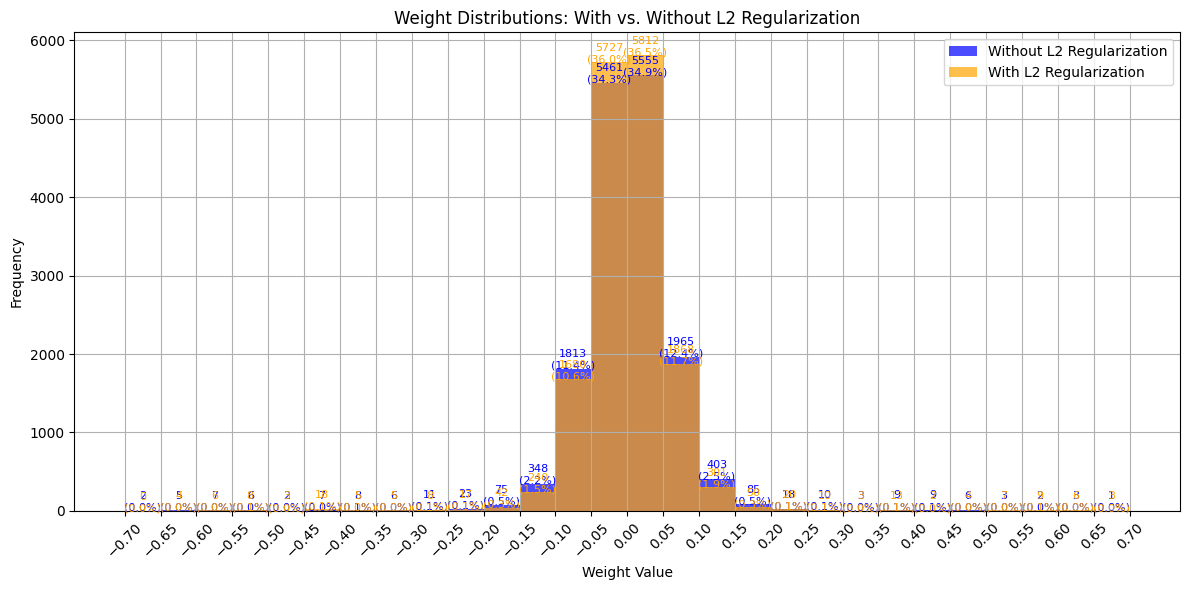

In [ ]:
# Import libraries
import matplotlib.pyplot as plt

# Define the functions for weight extraction and plotting
def extract_weights(parameters):
    """Flatten and collect all weights into a single list."""
    weights = []
    for key in parameters.keys():
        if 'W' in key:  # Extract only weight matrices
            weights.extend(parameters[key].detach().cpu().numpy().flatten())
    return weights


def plot_weight_distributions(weights_no_l2, weights_with_l2):
    """Plot histograms of weights with and without L2 regularization."""
    bins = np.arange(-0.7, 0.75, 0.05)  # Bins from -0.7 to 0.7 with steps of 0.05

    plt.figure(figsize=(12, 6))

    # Plot histogram for weights without L2
    counts_no_l2, _, _ = plt.hist(
        weights_no_l2, bins=bins, alpha=0.7, label='Without L2 Regularization', color='blue'
    )

    # Plot histogram for weights with L2
    counts_with_l2, _, _ = plt.hist(
        weights_with_l2, bins=bins, alpha=0.7, label='With L2 Regularization', color='orange'
    )

    # Annotate counts and percentages for each bin
    for i in range(len(bins) - 1):
        bin_center = (bins[i] + bins[i + 1]) / 2
        plt.text(
            bin_center,
            counts_no_l2[i] + 1,  # Offset for readability
            f"{int(counts_no_l2[i])}\n({counts_no_l2[i] / len(weights_no_l2) * 100:.1f}%)",
            ha='center',
            color='blue',
            fontsize=8,
        )
        plt.text(
            bin_center,
            counts_with_l2[i] - 5,  # Offset for readability
            f"{int(counts_with_l2[i])}\n({counts_with_l2[i] / len(weights_with_l2) * 100:.1f}%)",
            ha='center',
            color='orange',
            fontsize=8,
        )

    # Customize plot
    plt.title('Weight Distributions: With vs. Without L2 Regularization')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.xticks(bins, rotation=45)  # Ensure bins are clearly labeled
    plt.tight_layout()
    plt.show()


def train_model_with_epochs(X_train, Y_train, X_val, Y_val, layers_dims, learning_rate, batch_size, stopping_criterion, lambda_, seed=None):
    """Train the model over multiple epochs with early stopping."""
    num_iterations = X_train.shape[1] // batch_size
    max_epochs = 200
    parameters = None
    total_batches = 0
    steps_without_improvement = 0
    best_val = torch.inf
    costs = []
    use_batchnorm=False

    for epoch in range(max_epochs):
        parameters, costs, total_batches, steps_without_improvement, best_val, stop_run = l_layer_model(X_train, Y_train, layers_dims, learning_rate,
                                                                                                      num_iterations, batch_size, total_batches, steps_without_improvement,
                                                                                                      parameters, X_val, Y_val, stopping_criterion, costs, use_batchnorm, best_val=torch.inf, lambda_=0.0)

        if stop_run:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    return parameters

# Dataset preparation
X_train, Y_train, X_test, Y_test = load_and_split_mnist()
X_validation, Y_validation, X_train_new, Y_train_new = create_validation_set(X_train, Y_train)

# Define parameters
layers_dims = [784, 20, 7, 5, 10]  # Input size = 784 (28x28), Output size = 10 (classes)
learning_rate = 0.009
batch_size = 256
stopping_criterion = 100

# Train without L2 Regularization
print("Training without L2 Regularization...")
parameters_no_l2 = train_model_with_epochs(
    X_train_new, Y_train_new, X_validation, Y_validation,
    layers_dims, learning_rate, batch_size, stopping_criterion, lambda_=0.0, seed=44
)

# Train with L2 Regularization
print("Training with L2 Regularization...")
parameters_with_l2 = train_model_with_epochs(
    X_train_new, Y_train_new, X_validation, Y_validation,
    layers_dims, learning_rate, batch_size, stopping_criterion, lambda_=0.2, seed=45
)

# Extract weights
weights_no_l2 = extract_weights(parameters_no_l2)
weights_with_l2 = extract_weights(parameters_with_l2)

# Plot weight distributions
plot_weight_distributions(weights_no_l2, weights_with_l2)
# plot_weight_distributions(weights_no_l2, weights_with_l2)
